# COVID-19 Data Analyzation and Prediction
## Fan Li

## Preliminary Wrangling

> With 153,648 confirmed cases, 5,746 deaths, 146 countries were affected (*by March 15th*) by Coronavirus disease, this outbreak has gone way beyond what we expected. This pandemic had WHO (*World Health Organization*) raised the health emergency to its highest level along with many more countries top emergency warnings. This project is targeted to briefly analyze COVID outbreak in United States, some comparison against China (worst hit area) along with a rough prediction of spreading trend. Data set is operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Also, Supported by ESRI Living Atlas Team and the Johns Hopkins University Applied Physics Lab (JHU APL).

 **This project is out of personal interest and it is for demonstration only, it should not be used for academical research nor clinical purpose.**

In [48]:
## import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
%matplotlib inline
from scipy.optimize import curve_fit
import urllib
import time

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# Data Gathering

In [3]:
## csv files read in
path = r'csse_covid_19_data/csse_covid_19_daily_reports'
all_files = glob.glob(path + "/*.csv")
## concat into one file
li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0)
    """if there is no new confirms on that day, 'Last Update' will stay at yesterday,
    this will have a misleading result on the plot when we draw accumulated confirmed cases by date,
    therefor we change the 'Last Update' to the same as the file name, which is the calendar date
    """
    df['Last Update']= filename[-14:-4]
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True, sort= True)

In [4]:
frame

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered
0,1.0,Mainland China,NaN,01-22-2020,NaN,NaN,Anhui,NaN
1,14.0,Mainland China,NaN,01-22-2020,NaN,NaN,Beijing,NaN
2,6.0,Mainland China,NaN,01-22-2020,NaN,NaN,Chongqing,NaN
3,1.0,Mainland China,NaN,01-22-2020,NaN,NaN,Fujian,NaN
4,NaN,Mainland China,NaN,01-22-2020,NaN,NaN,Gansu,NaN
...,...,...,...,...,...,...,...,...
5882,1.0,United Kingdom,0.0,03-15-2020,36.1408,-5.3536,Gibraltar,1.0
5883,1.0,Uzbekistan,0.0,03-15-2020,41.3775,64.5853,NaN,0.0
5884,0.0,Australia,0.0,03-15-2020,35.4437,139.6380,From Diamond Princess,0.0
5885,0.0,US,0.0,03-15-2020,38.4912,-80.9545,West Virginia,0.0


# Data Cleaning

In [5]:
## rename two columns with non-sensitive notation
frame.rename(columns ={'Country/Region':'Country_Region','Province/State':'Province_State',
                       'Last Update':'Last_Update'}, inplace= True)

In [6]:
## filter out U.S. and China
df = frame.query('Country_Region == "US" or Country_Region == "China" or Country_Region == "Mainland China"')
## replace "Mainland China" with "China"
df['Country_Region'].replace('Mainland China','China',inplace= True)

In [7]:
## test
df['Country_Region'].value_counts()

China    1682
US       1218
Name: Country_Region, dtype: int64

In [8]:
## check duplicates
df.duplicated().any()

False

In [9]:
## rerange columns
df = df[['Province_State','Country_Region','Last_Update','Confirmed','Deaths','Recovered','Latitude','Longitude']]

In [10]:
## test
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 5885
Data columns (total 8 columns):
Province_State    2900 non-null object
Country_Region    2900 non-null object
Last_Update       2900 non-null object
Confirmed         2888 non-null float64
Deaths            2618 non-null float64
Recovered         2657 non-null float64
Latitude          1323 non-null float64
Longitude         1323 non-null float64
dtypes: float64(5), object(3)
memory usage: 203.9+ KB


In [11]:
## fill NaN with 0 in 'Confirmed','Deaths','Recovered'
df[['Confirmed','Deaths','Recovered']]= df[['Confirmed','Deaths','Recovered']].fillna(0)
df

,Province_State,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Anhui,China,01-22-2020,1.0,0.0,0.0,NaN,NaN
1,Beijing,China,01-22-2020,14.0,0.0,0.0,NaN,NaN
2,Chongqing,China,01-22-2020,6.0,0.0,0.0,NaN,NaN
3,Fujian,China,01-22-2020,1.0,0.0,0.0,NaN,NaN
4,Gansu,China,01-22-2020,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
5854,Tibet,China,03-15-2020,1.0,0.0,1.0,31.6927,88.0924
5879,Alaska,US,03-15-2020,1.0,0.0,0.0,61.3707,-152.4044
5880,North Dakota,US,03-15-2020,1.0,0.0,0.0,47.5289,-99.7840
5881,"Virgin Islands, U.S.",US,03-15-2020,1.0,0.0,0.0,18.3358,-64.8963


In [12]:
## change datatype
integer = ['Confirmed','Deaths','Recovered']
datetime = ['Last_Update']
datatypes = ['int','datetime64']
columns = [integer,datetime]
for column,datatype in zip(columns,datatypes):
    df[column]= df[column].astype(datatype)

In [13]:
## trim down HH-MM-SS
df['Last_Update'] = df['Last_Update'].values.astype('<M8[D]')

In [14]:
## reset index
df.reset_index(inplace= True)
## drop old index
df.drop(['index'],axis =1,inplace= True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
Province_State    2900 non-null object
Country_Region    2900 non-null object
Last_Update       2900 non-null datetime64[ns]
Confirmed         2900 non-null int32
Deaths            2900 non-null int32
Recovered         2900 non-null int32
Latitude          1323 non-null float64
Longitude         1323 non-null float64
dtypes: datetime64[ns](1), float64(2), int32(3), object(2)
memory usage: 147.4+ KB


In [16]:
## Add fatality rate and recovery rate
df['fatality_rate'] = df['Deaths']/df['Confirmed']
df['recovery_rate'] = df['Recovered']/df['Confirmed']

In [17]:
## test
df.head()

,Province_State,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Latitude,Longitude,fatality_rate,recovery_rate
0,Anhui,China,2020-01-22,1,0,0,NaN,NaN,0.0,0.0
1,Beijing,China,2020-01-22,14,0,0,NaN,NaN,0.0,0.0
2,Chongqing,China,2020-01-22,6,0,0,NaN,NaN,0.0,0.0
3,Fujian,China,2020-01-22,1,0,0,NaN,NaN,0.0,0.0
4,Gansu,China,2020-01-22,0,0,0,NaN,NaN,NaN,NaN


In [18]:
print(df.query('Country_Region == "China"').shape[0],df.query('Country_Region == "US"').shape[0])

1682 1218


In [19]:
## break data by contries for future analyzation
usdf = df.query('Country_Region == "US"')
cndf = df.query('Country_Region == "China"')

### What is the structure of your dataset?

> There are 2900 records in totoal, 1682 records in China and 1218 records in the U.S.. Information is recorded from 2020 Jan 22nd until 2020 Mar 15th.

### What is/are the main feature(s) of interest in your dataset?

> The relationship among Confirmed,Deaths,Recovered alone with time goes on in two different countries.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Confirmed,Deaths,Recovered are key metrics. With some engineering will result different ratios.

## Univariate Exploration

In [20]:
usdf.describe()

,Confirmed,Deaths,Recovered,Latitude,Longitude,fatality_rate,recovery_rate
count,1218.000000,1218.000000,1218.000000,844.000000,844.000000,1143.000000,1143.000000
mean,12.784893,0.311987,0.182266,38.543206,-92.981923,0.009713,0.076627
std,52.066512,2.556099,0.556973,5.810390,38.066115,0.065576,0.244124
min,0.000000,0.000000,0.000000,13.444300,-157.858400,0.000000,0.000000
25%,1.000000,0.000000,0.000000,35.443700,-118.243700,0.000000,0.000000
50%,2.000000,0.000000,0.000000,39.059800,-93.210500,0.000000,0.000000
75%,5.000000,0.000000,0.000000,42.165700,-78.566100,0.000000,0.000000
max,732.000000,40.000000,6.000000,61.370716,144.793700,1.000000,1.000000


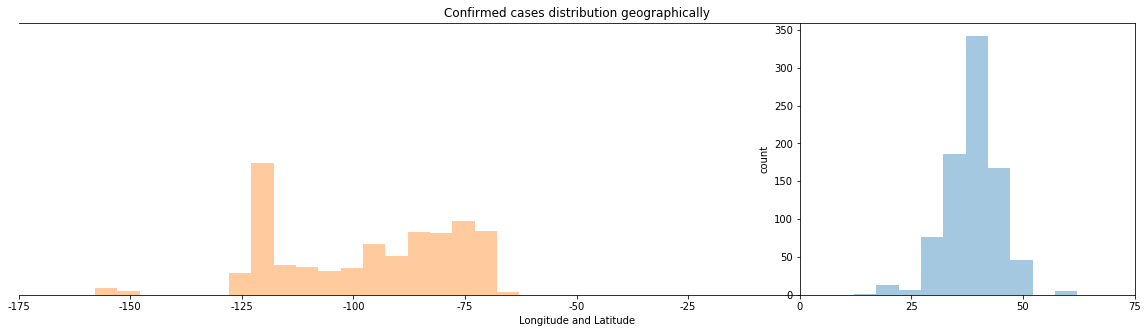

In [21]:
## set bin edge
bin_edge = np.arange(usdf['Longitude'].min(),usdf['Latitude'].max()+5,5)
## plot
plt.figure(figsize =(20,5))
## set y axis to x= 0
plt.axes().spines['left'].set_position(('data',0))
sns.distplot(usdf['Latitude'],bins =bin_edge,kde =False)
sns.distplot(usdf['Longitude'], bins =bin_edge, kde= False)
## set xticks
tick = np.arange(-175,100, 25)
plt.xticks(tick,tick)
## set labels
plt.xlabel('Longitude and Latitude')
plt.ylabel('count')
plt.title('Confirmed cases distribution geographically');

> Plot indicates pandemic's distribution on geographic perspective.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Given the fact that this plot is based on frequencies of geographical values show up in the data set, we don’t expect any correlation or normal distribution show up in the plot but only to reflect the way COVID spread out from the geographical perspective. The plot shows the virus on record is between (-160, -65) in longitude and between(20,65) in latitude. In relate, Lat-long coorditates for cities in United States are in range: Latitude from 19.50139 to 64.85694 and longitude from -161.75583 to -68.01197. This match up with what we have in the plot.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> More specifically, there are two humps in the Longitude distribution plot, they reflect more cases on both coasts. Other the other hand, there is a significant high volume in the latitude plot which occurs around 40 to 45 latitude. This draws my attention to WA, Northern CA, OR and Northern east coast states around NY.

## Bivariate Exploration

###### accumulated numbers among states
Bacause Confirmed,Deaths,Recovered are accumulative numbers, I decided to use the most up-to-date record, which is on Mar 15th to preseed following investigation.

In [22]:
## mask
mask = usdf.query('Last_Update == "03-15-2020"')

In [23]:
## set up iterables
deathcols = ['Deaths','fatality_rate']
recovercols= ['Recovered','recovery_rate']
plotpos =[121,122]
def statenum(colums):
    plt.figure(figsize=(20,10))
    ## sort values descending
    if colums =='Confirmed':
        statedesc = mask.groupby('Province_State')[colums].sum().sort_values(ascending= False)
        sns.barplot(data=mask, x= statedesc.values,y = statedesc.index, color ='c')
        plt.xlabel(colums)
        plt.title('Total confirmed cases each state')
    ## limit result returned by 10 with small recoreds size
    else:
        for colum, plotpo in zip(colums,plotpos):
            plt.subplot(plotpo)
            i = mask.groupby('Province_State')[colum].sum().sort_values(ascending= False)[:12]
            sns.barplot(data=mask, y= i.values,x = i.index, color ='c')
            plt.xticks(rotation =15)
            plt.ylabel(colum)
            plt.title('Top 12 {} states'.format(colum))

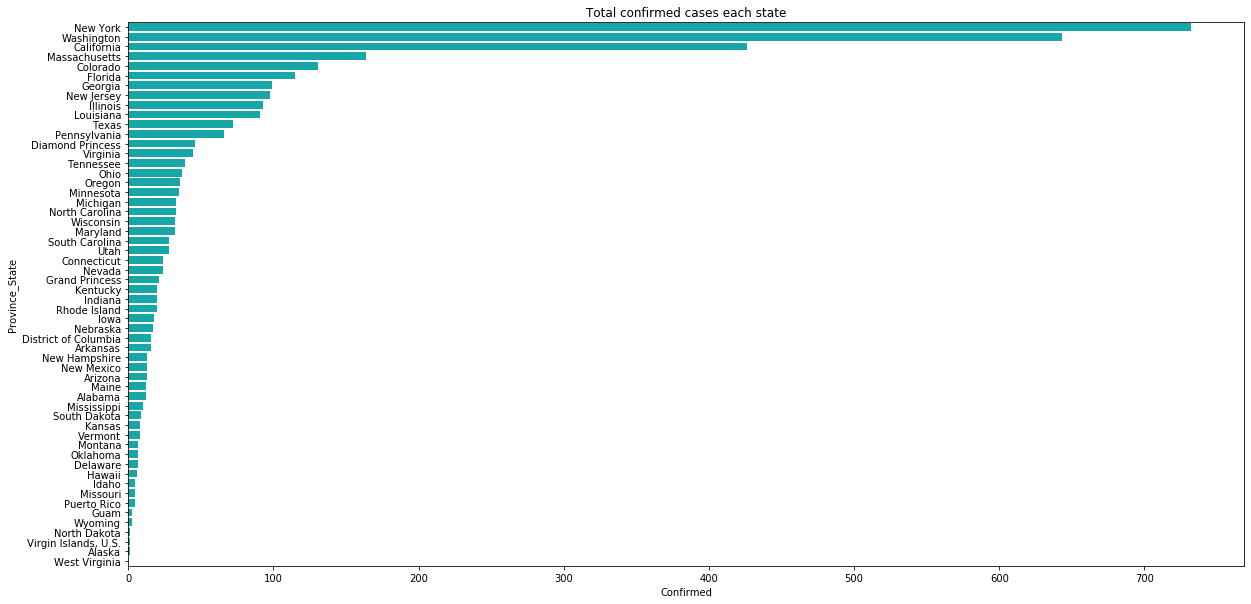

In [24]:
statenum('Confirmed')

> This agree with my hypothesis: Northern east and Northern west states have the most cases reported. Top four significant states are WA, NY, CA and MA.

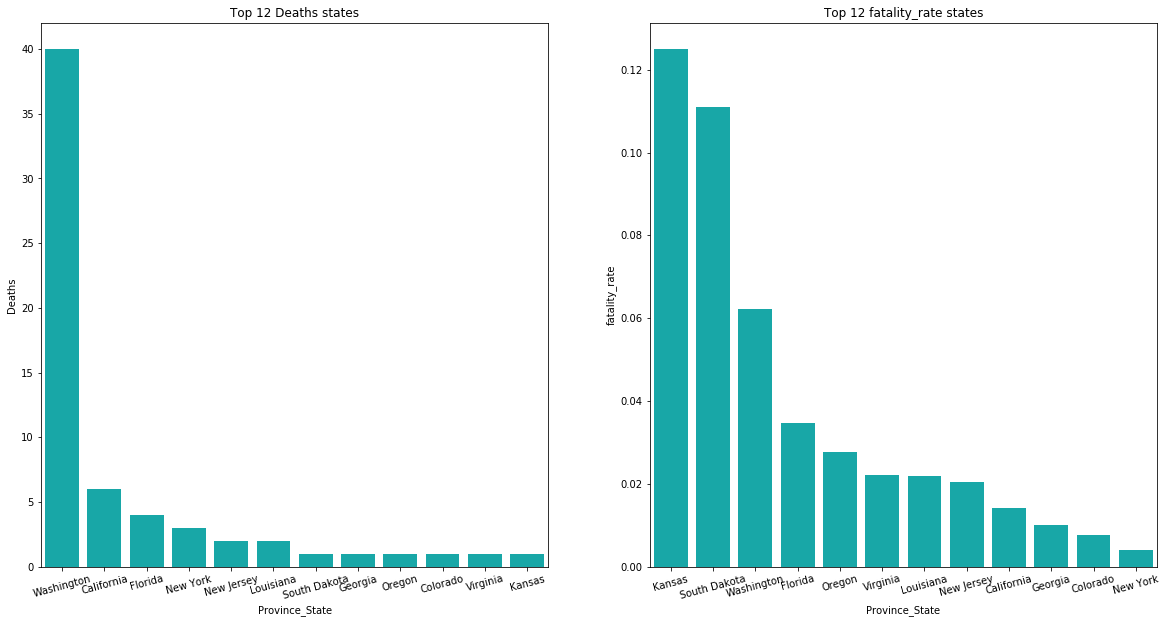

In [25]:
statenum(deathcols)

> total deaths show different results than fatality rate

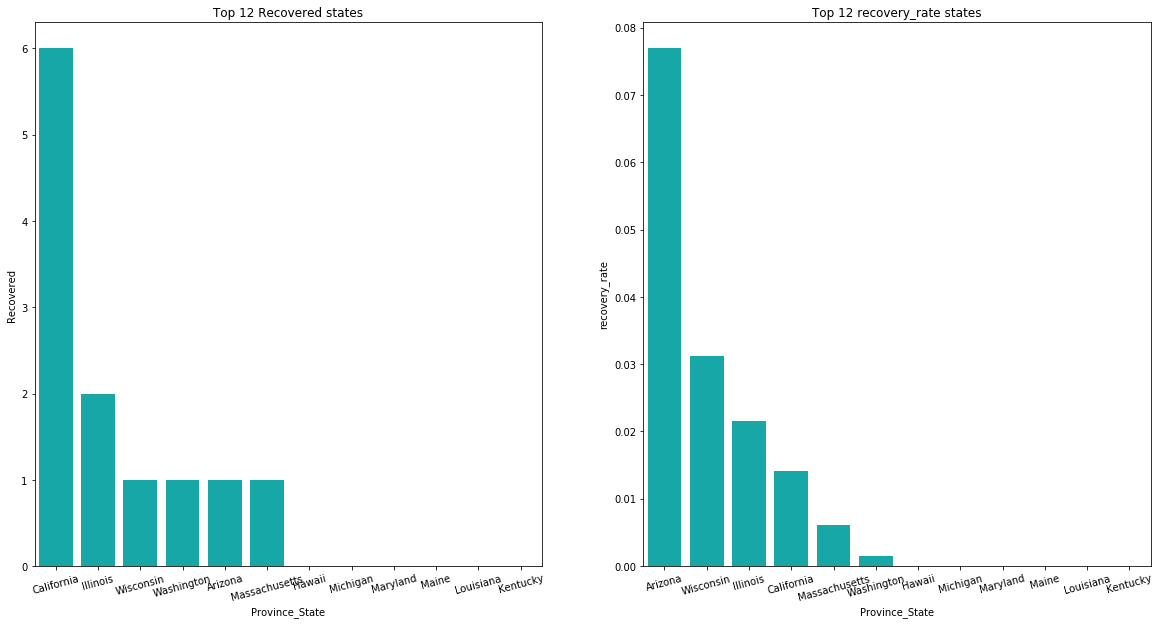

In [26]:
statenum(recovercols)

> total recoverying show different results than recovery rate

###### Accumulate confirmed cases along time

In [27]:
def timematric(matric):
    plt.figure(figsize=(20,5))
    usdata = usdf.groupby('Last_Update')[matric].sum()
    sns.lineplot(data=usdf, x =usdata.index, y = usdata.values )
    plt.title('Accumulate {} cases along with time'.format(matric))

C:\Users\victo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


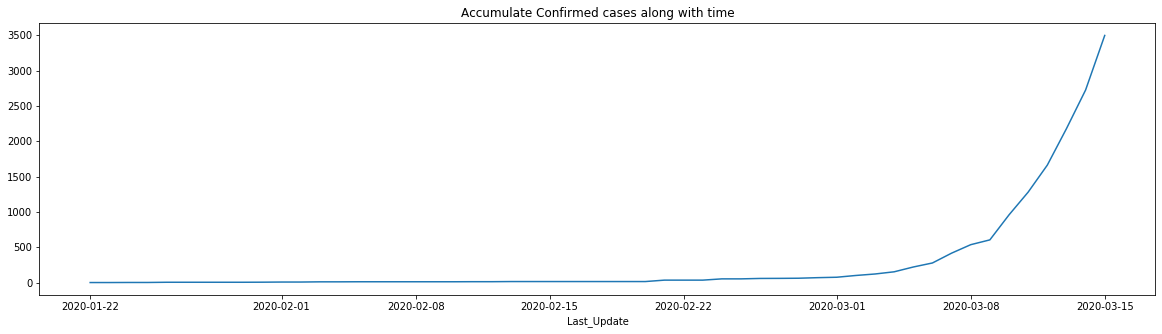

In [28]:
timematric('Confirmed')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> From the 'Total confirmed cases each state' plot we can see top four significant states are WA, NY, CA and MA. This agree with my hypothesis: Northern east and Northern west states have the most cases reported. From the accumulate confirmed cases plot we can see boost started around March 1st.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> The total deaths/state and fatality rate/state as well as total recoveries/state and recovery rate/state are paired based on the same group of data but showing different results. They also suggest slightly different messages, using ratios might be a better way to compare event/person by state.

## Multivariate Exploration

###### Comparing COVID spread  speed within China and U.S.

In [29]:
## aggregate by conuntries then create multi index series
countrydf = df.groupby(['Country_Region','Last_Update'])[['Confirmed','Deaths','Recovered']].sum()
## reset index
countrydf = countrydf.reset_index()

In [30]:
## test
countrydf

,Country_Region,Last_Update,Confirmed,Deaths,Recovered
0,China,2020-01-22,547,17,28
1,China,2020-01-23,639,18,30
2,China,2020-01-24,916,26,36
3,China,2020-01-25,1399,42,39
4,China,2020-01-26,2062,56,49
...,...,...,...,...,...
103,US,2020-03-11,1281,36,8
104,US,2020-03-12,1663,40,12
105,US,2020-03-13,2179,47,12
106,US,2020-03-14,2726,54,12


In [31]:
## function for compute logarithm and antilogarithm
def logtrans(x, inverse= False):
    if not inverse:
        return np.log10(x)
    else:
        return 10 ** x

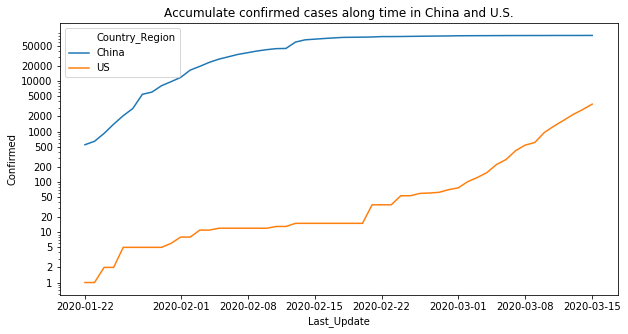

In [32]:
## transform y scale to log10 in order 
## to counter big population difference
plt.figure(figsize=(10,5))
plt.yscale('log')
sns.lineplot(data=countrydf, x ='Last_Update', y = 'Confirmed',hue= 'Country_Region' )
tick = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000]
plt.yticks(tick,tick)
plt.legend(loc =0)
plt.title('Accumulate confirmed cases along time in China and U.S.');

> Here we have a plot showing accumulate confirmed cases along with time between China and U.S.. There is a worrisome trend, from Jan 22nd the first COVID-19 case was observed in the U.S. it has been slowly spreading out unilt Fed 22nd a big population was infected and it started to spread out fast, giving the same frame of time the virus is spreading faster in the U.S. than in China at this moment.

###### Total Recovered and total Deaths between two countries

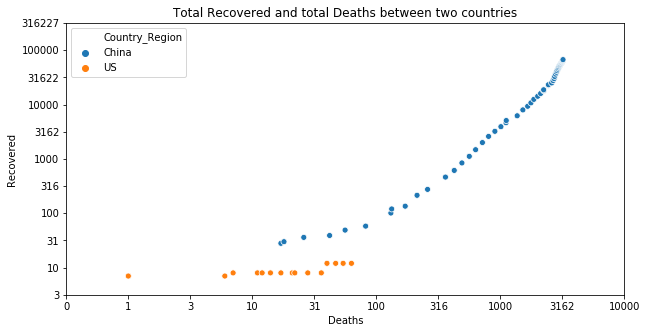

In [33]:
plt.figure(figsize=(10,5))
## perform log transformation
sns.scatterplot(data= countrydf,y= countrydf['Recovered'].apply(logtrans),
                x =countrydf['Deaths'].apply(logtrans), hue= 'Country_Region')
## get x,t ticks locations and labels
xlocs, xlabels= plt.xticks()
ylocs, ylabels= plt.yticks()
## transform labels
xlabels = logtrans(xlocs, inverse= True).astype(int)
ylabels = logtrans(ylocs, inverse= True).astype(int)
plt.xticks(xlocs, xlabels)
plt.yticks(ylocs, ylabels)
plt.legend(loc= 0)
plt.title('Total Recovered and total Deaths between two countries');

> Scatter plot show a relationship between total Recovered and total Deaths within two countries. This make sense because more recovered reflect more cases confirmed which will lead to more deaths. What we want to see is a steep slop along those spots, the steeper slop is the more people recovered than died. In this case, China shows a more comforting result.

###### Average ratio comparisons

In [34]:
## Add fatality rate and recovery rate
countrydf['fatality_rate'] = countrydf['Deaths']/countrydf['Confirmed']
countrydf['recovery_rate'] = countrydf['Recovered']/countrydf['Confirmed']
countrydf

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,fatality_rate,recovery_rate
0,China,2020-01-22,547,17,28,0.031079,0.051188
1,China,2020-01-23,639,18,30,0.028169,0.046948
2,China,2020-01-24,916,26,36,0.028384,0.039301
3,China,2020-01-25,1399,42,39,0.030021,0.027877
4,China,2020-01-26,2062,56,49,0.027158,0.023763
...,...,...,...,...,...,...,...
103,US,2020-03-11,1281,36,8,0.028103,0.006245
104,US,2020-03-12,1663,40,12,0.024053,0.007216
105,US,2020-03-13,2179,47,12,0.021570,0.005507
106,US,2020-03-14,2726,54,12,0.019809,0.004402


In [35]:
uptodate = countrydf.query('Last_Update=="2020-03-15"')
uptodate

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,fatality_rate,recovery_rate
53,China,2020-03-15,81003,3203,67017,0.039542,0.82734
107,US,2020-03-15,3499,63,12,0.018005,0.00343


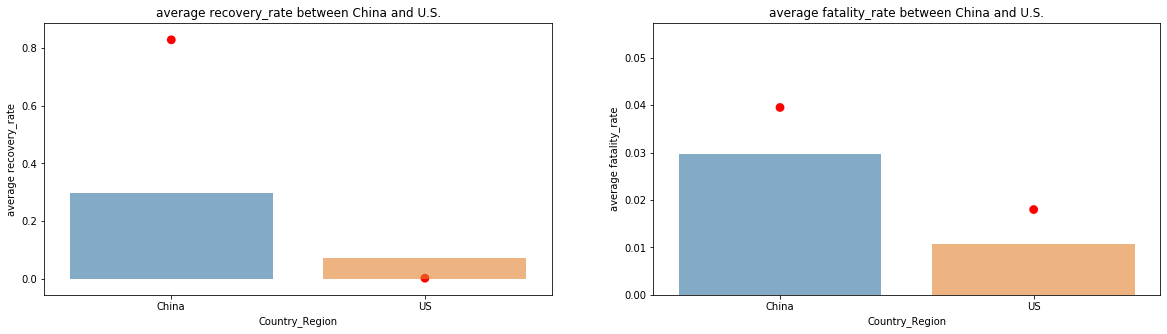

In [36]:
indexes = [121, 122]
columnames =['recovery_rate','fatality_rate']
plt.figure(figsize=(20,5))
for index, columname in zip(indexes,columnames):
    plt.subplot(index)
    ## use red dot to indicate most recent rates
    sns.pointplot(data = uptodate, x = 'Country_Region', y= columname,color ='r',join =False,edgecolors="white")
    sns.barplot(data= countrydf, x= 'Country_Region', y= columname, ci= False, alpha = 0.6)
    plt.ylabel('average {}'.format(columname))
    plt.title('average {} between China and U.S.'.format(columname));

> Plots above compare average recovery rate as well as average fatality rate between two contries. Fortunately both counrties showing a higher average recovery rate than average fatality rate. Red dots represent rates on Mar 15th respectively.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> "Total Recovered and total Deaths between two contries" plot show a relationship between total Recovered and total Deaths within two countries. This make sense because more recovered reflect more cases confirmed which will lead to more deaths. What we want to see is a steep slop along those spots, the steeper slop is the more people recovered than died. In this case, China shows a more comforting result.
### Were there any interesting or surprising interactions between features?

> "Accumulate confirmed cases along with time in China and U.S." shows a worrisome trend, from Jan 22nd the first COVID-19 case was observed in the U.S. it has been slowly spreading out unilt Fed 22nd a big population was infected and it started to spread out fast, giving the same frame of time the virus is spreading faster in the U.S. than in China at this moment.

## Prediction

In [60]:
dummydf = countrydf.query('Country_Region=="US"')
dummydf['Confirmed'].values

array([   1,    1,    2,    2,    5,    5,    5,    5,    5,    6,    8,
          8,   11,   11,   12,   12,   12,   12,   12,   12,   13,   13,
         15,   15,   15,   15,   15,   15,   15,   15,   35,   35,   35,
         53,   53,   59,   60,   62,   70,   76,  101,  122,  153,  221,
        278,  417,  537,  605,  959, 1281, 1663, 2179, 2726, 3499])

In [ ]:
## function for obtain dates from Jan 22nd
def get_date_list(target_month = 3):
    month_day = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    cur_month, cur_day = 1, 22
    ans = []
    while cur_month <= target_month:
        while cur_day <= month_day[cur_month]:
            d = "0" + str(cur_day) if cur_day < 10 else str(cur_day)
            ans += [str(cur_month) + "/" + d]
            cur_day += 1
        cur_day = 1
        cur_month += 1
    return ans

In [ ]:
## logistic function model
def logistic_function(t, K, P0, r):
    t0 = 0
    exp = np.exp(r * (t - t0))
    return (K * exp * P0) / (K + (exp - 1) * P0)

In [105]:
## main function body
def predict(dayframe):
    ## how many days to predicte from today
    ## aka dayframe
    predict_days = dayframe
    
    date, confirm = dummydf['Last_Update'].values, dummydf['Confirmed'].values
    x = np.arange(len(confirm))
    date_labels = get_date_list(4)
    
    ## convert least sqrt
    popt, pcov = curve_fit(logistic_function, x, confirm, maxfev=9000)
    #print(popt)
    
    predict_x = list(x) + [x[-1] + i for i in range(1, 1 + predict_days)]
    predict_x = np.array(predict_x)
    predict_y = logistic_function(predict_x, popt[0], popt[1], popt[2])
    
    ## plot
    plt.figure(figsize=(20, 10))
    plt.plot(predict_x, predict_y, 's',label="predicted infected number",alpha= 0.6)
    plt.plot(x, confirm, 'o',label="confimed infected number")
    plt.xticks(predict_x, date_labels[:len(predict_x) + 1], rotation=90)
       
    plt.suptitle("U.S. region COVID-19 infected numbers prediction (Max infections: {},  r:{:.3})".format(int(popt[0]),
                                                                                popt[2]), fontsize=16, fontweight="bold")
    plt.title("Predict time:{}".format(time.strftime("%Y-%m-%d", time.localtime())), fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('infected number', fontsize=14)
    plt.legend(loc= 0)

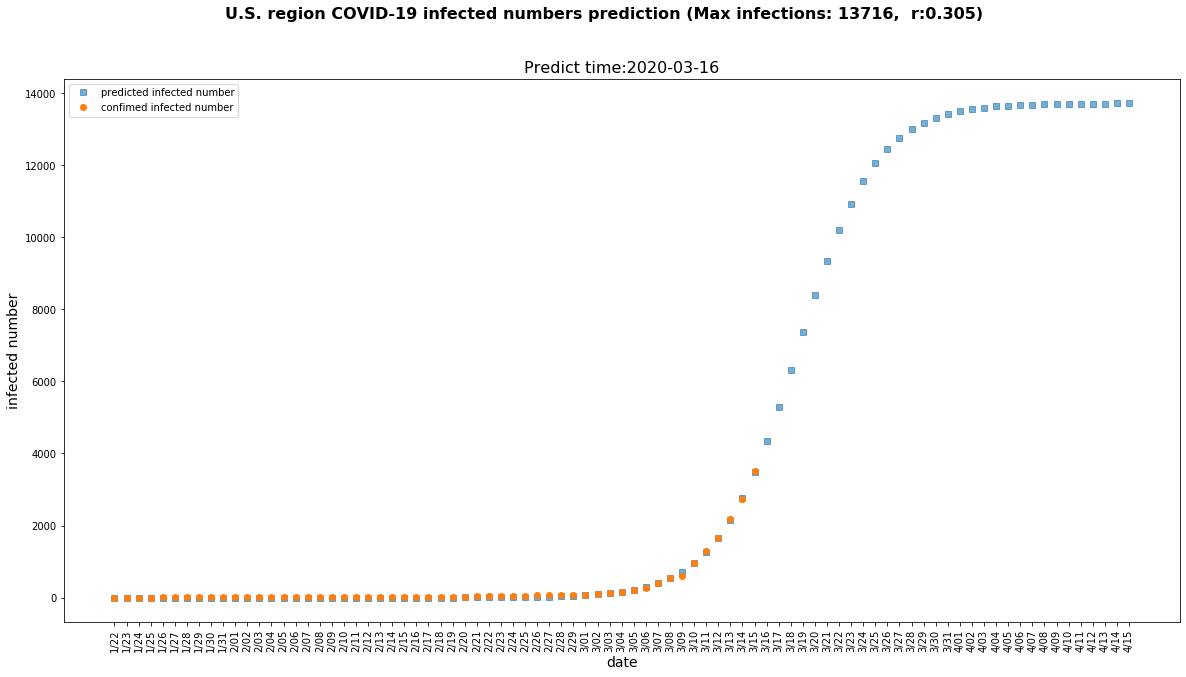

In [106]:
## call function using 31 dayframe
predict(31)

> Above is a prediction model using logistic growth algorithm. In the title, max infections represent predicted maximum total confirmed cases, r is the per capita rate of increase, the greater r is the faster to reach the peak point. As the model shows, max confirmed cases would likely be around 13716, which will happen around April 6th. This model has very limited perspective, dataset is not large enough to train the model at this point(represented by orange dots), also it has not yet take other elements into consideration, eg SEIR model, SIRS model, susceptible and infective mobility, medical break though and many more.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!